[I 2025-09-21 21:39:08,276] A new study created in memory with name: no-name-e5f33830-1aae-402e-89e2-1de52df84082
21:39:08 - cmdstanpy - INFO - Chain [1] start processing
21:39:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-21 21:39:08,536] Trial 0 finished with value: 269.4926367603803 and parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.06384569445382109, 'seasonality_prior_scale': 8.275112701123396, 'yearly_seasonality': 10}. Best is trial 0 with value: 269.4926367603803.
21:39:08 - cmdstanpy - INFO - Chain [1] start processing
21:39:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-21 21:39:10,960] Trial 1 finished with value: 107.03225798167016 and parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.017660147784204515, 'seasonality_prior_scale': 3.7880674253085713, 'yearly_seasonality': 15}. Best is trial 1 with value: 107.03225798167016.
21:39:11 - cmdstanpy - INFO - Chain [1] start processing
21:39:11 

Best params: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.21274761217676208, 'seasonality_prior_scale': 2.6604449120755866, 'yearly_seasonality': 6}
Best MAPE : 24.01180129949245
MAE (test):  0.00
MAPE (test): 24.01%


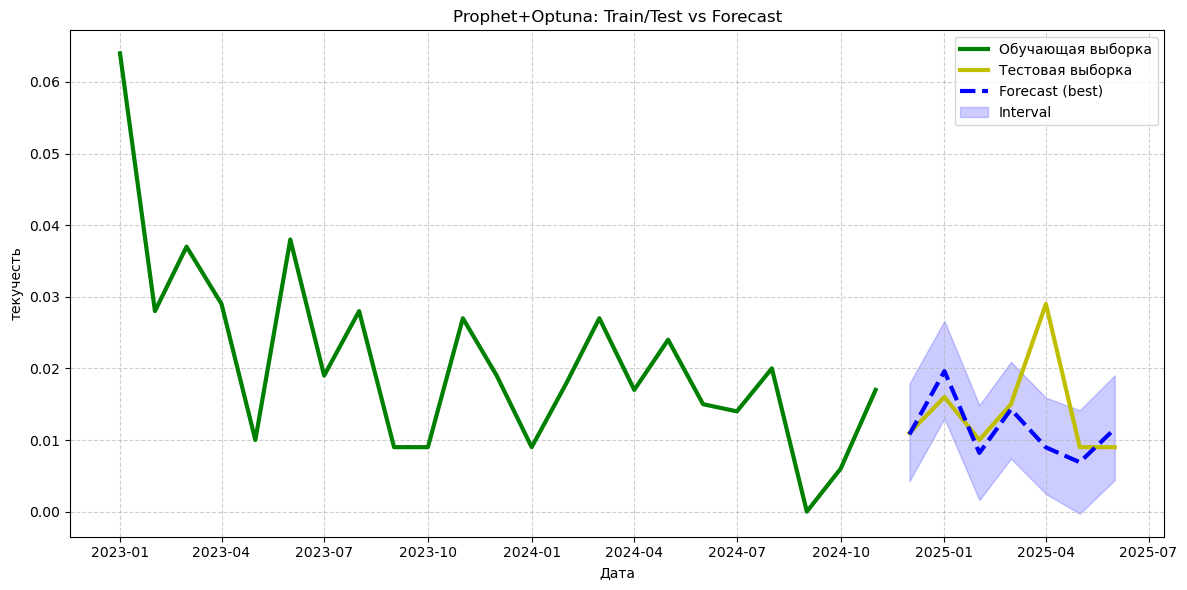

21:39:48 - cmdstanpy - INFO - Chain [1] start processing
21:39:48 - cmdstanpy - INFO - Chain [1] done processing



Прогноз на следующие 12 месяцев (yhat, lower, upper):
           ds  yhat  yhat_lower  yhat_upper
30 2025-07-01  0.01        0.00        0.02
31 2025-08-01  0.01        0.00        0.02
32 2025-09-01  0.00       -0.00        0.01
33 2025-10-01  0.00       -0.00        0.01
34 2025-11-01  0.01        0.01        0.02
35 2025-12-01  0.01        0.00        0.02
36 2026-01-01  0.01        0.01        0.02
37 2026-02-01  0.01        0.00        0.02
38 2026-03-01  0.01        0.00        0.02
39 2026-04-01  0.01        0.00        0.02
40 2026-05-01  0.01       -0.00        0.01
41 2026-06-01  0.01        0.00        0.02


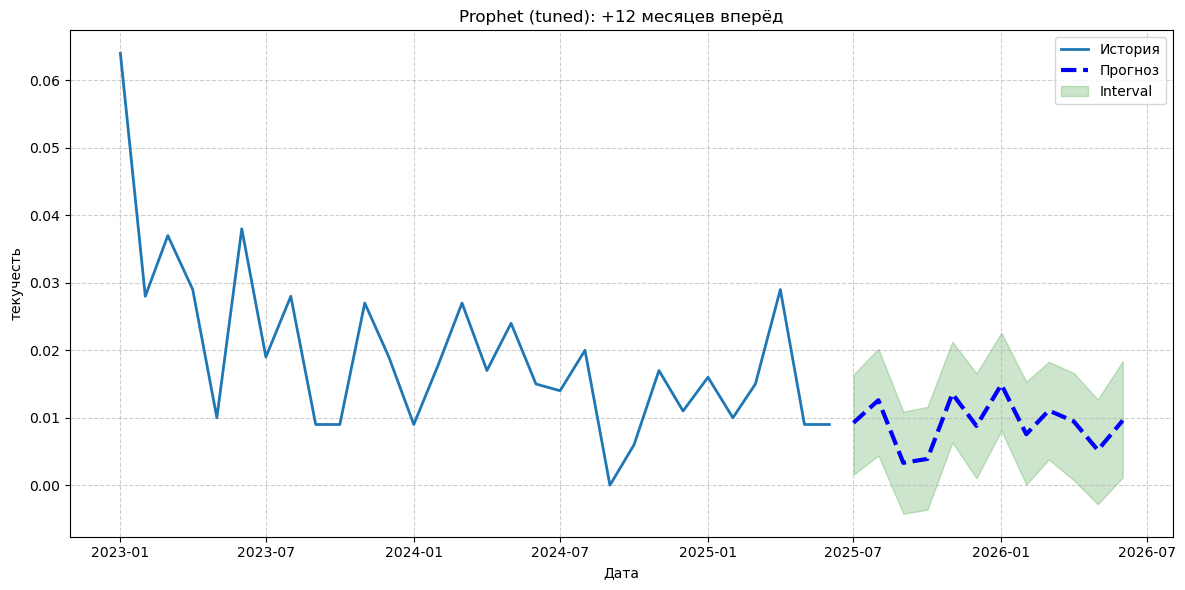

In [7]:
# !pip install prophet optuna --quiet
'''
Prophet- модель (математический алгоритм прогнозирования временных рядов: тренд + сезонность + праздники).
y(t)=g(t)+s(t)+h(t)+ε
g(t) — тренд (кусочно-линейный или логистический).
s(t) — сезонности.
h(t) — праздники/события (если заданы).
εt — ошибка.
_________
СЕЗОННОСТИ:
1.Годовая (yearly_seasonality) — реализована через Фурье-ряды.
2.Еженедельная и дневная — по умолчанию отключены, если данные месячные.
3. Дополнительные сезонности можно явно добавить (m.add_seasonality(...)).
Режим сезонности:
additive → сезонность просто добавляется к тренду.
multiplicative → сезонность растёт вместе с трендом (амплитуда увеличивается).

Prophet «разбивает» твой ряд на тренд и сезонность (через Фурье), Optuna перебирает гиперпараметры.
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Загрузка и подготовка
df = pd.read_excel("turnover_drp.xlsx")
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y', errors='coerce')
df['turnover'] = pd.to_numeric(df['turnover'], errors='coerce')
df = df.dropna(subset=['date','turnover']).sort_values('date')
df = df.set_index('date').asfreq('MS').reset_index()   # месячная частота
data = df.rename(columns={'date':'ds', 'turnover':'y'})

# Train/Test 
H = min(12, max(3, len(data)//4))  # на коротких рядах — гибкий горизонт
train = data.iloc[:-H].copy()
test  = data.iloc[-H:].copy()

def safe_mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(y_true == 0, np.nan, y_true)
    return float(np.nanmean(np.abs((y_true - y_pred) / denom)) * 100)

# Целевая функция Optuna (без CV для коротких рядов)
def objective(trial):
    params = {
        "seasonality_mode": trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"]),
        "changepoint_prior_scale": trial.suggest_float("changepoint_prior_scale", 0.01, 1.0, log=True),
        "seasonality_prior_scale": trial.suggest_float("seasonality_prior_scale", 0.1, 10.0, log=True),
        "yearly_seasonality": trial.suggest_int("yearly_seasonality", 5, 15),
    }
    m = Prophet(
        growth="linear",
        weekly_seasonality=False,
        daily_seasonality=False,
        **params
    )
    m.fit(train)
    future = m.make_future_dataframe(periods=H, freq='MS')
    fcst = m.predict(future).tail(H)

    return safe_mape(test['y'], fcst['yhat'])

# Тюнинг
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

best = study.best_params
print("Best params:", best)
print("Best MAPE :", study.best_value)

# Лучшая модель → метрики на тесте
m_best = Prophet(
    growth="linear",
    weekly_seasonality=False,
    daily_seasonality=False,
    **best
)
m_best.fit(train)
future_test = m_best.make_future_dataframe(periods=H, freq='MS')
fcst_test = m_best.predict(future_test).tail(H)

mae_test  = mean_absolute_error(test['y'], fcst_test['yhat'])
mape_test = safe_mape(test['y'], fcst_test['yhat'])
print(f"MAE (test):  {mae_test:.2f}")
print(f"MAPE (test): {mape_test:.2f}%")

# График: Train/Test vs Forecast
plt.figure(figsize=(12,6))
plt.plot(train['ds'], train['y'], label='Обучающая выборка', linewidth=3, color = 'green')
plt.plot(test['ds'],  test['y'],  label='Тестовая выборка',  linewidth=3, color='y')
plt.plot(fcst_test['ds'], fcst_test['yhat'], label='Forecast (best)', linewidth=3, color='blue', linestyle='--')
plt.fill_between(fcst_test['ds'], fcst_test['yhat_lower'], fcst_test['yhat_upper'], alpha=0.2, color='blue', label='Interval')
plt.title("Prophet+Optuna: Train/Test vs Forecast")
plt.xlabel("Дата"); plt.ylabel("текучесть")
plt.grid(True, linestyle="--", alpha=0.6); plt.legend(); plt.tight_layout(); plt.show()

# Прогноз на следующие 12 месяцев от конца ВСЕХ данных
m_full = Prophet(
    growth="linear",
    weekly_seasonality=False,
    daily_seasonality=False,
    **best
)
m_full.fit(data)
future_12 = m_full.make_future_dataframe(periods=12, freq='MS')
fcst_12 = m_full.predict(future_12).tail(12)

print("\nПрогноз на следующие 12 месяцев (yhat, lower, upper):")
print(fcst_12[['ds','yhat','yhat_lower','yhat_upper']].round(2))

# График: исторические данные + 12M вперёд
plt.figure(figsize=(12,6))
plt.plot(data['ds'], data['y'], label='История', linewidth=2)
plt.plot(fcst_12['ds'], fcst_12['yhat'], label='Прогноз', linewidth=3, color='blue', linestyle='--')
plt.fill_between(fcst_12['ds'], fcst_12['yhat_lower'], fcst_12['yhat_upper'], alpha=0.2, color='blue', label='Interval')
plt.title("Прогноз текучести")
plt.xlabel("Дата"); plt.ylabel("текучесть")
plt.grid(True, linestyle="--", alpha=0.6); plt.legend(); plt.tight_layout(); plt.show()
